<a href="https://colab.research.google.com/github/KomilovQobiljon/AIApplicationCourse/blob/main/AIApplicationWeek11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
# Save datagenerators as file to colab working directory
# If  you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import
with open('utilities.py', 'w') as f:
  f.write(r.text)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/book_store_sales.csv'

def readfile(file_name):
  file = open(file_name, 'r', encoding = 'utf-8')
  next(file)
  data = []
  for line in (file):
    values = line.split(',')
    print(values)
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

['Jan-1992', '790\n']
['Feb-1992', '539\n']
['Mar-1992', '535\n']
['Apr-1992', '523\n']
['May-1992', '552\n']
['Jun-1992', '589\n']
['Jul-1992', '592\n']
['Aug-1992', '894\n']
['Sep-1992', '861\n']
['Oct-1992', '645\n']
['Nov-1992', '642\n']
['Dec-1992', '1165\n']
['Jan-1993', '998\n']
['Feb-1993', '568\n']
['Mar-1993', '602\n']
['Apr-1993', '583\n']
['May-1993', '612\n']
['Jun-1993', '618\n']
['Jul-1993', '607\n']
['Aug-1993', '983\n']
['Sep-1993', '903\n']
['Oct-1993', '669\n']
['Nov-1993', '692\n']
['Dec-1993', '1273\n']
['Jan-1994', '1053\n']
['Feb-1994', '635\n']
['Mar-1994', '634\n']
['Apr-1994', '610\n']
['May-1994', '684\n']
['Jun-1994', '724\n']
['Jul-1994', '678\n']
['Aug-1994', '1154\n']
['Sep-1994', '1022\n']
['Oct-1994', '732\n']
['Nov-1994', '772\n']
['Dec-1994', '1409\n']
['Jan-1995', '1308\n']
['Feb-1995', '718\n']
['Mar-1995', '695\n']
['Apr-1995', '688\n']
['May-1995', '785\n']
['Jun-1995', '808\n']
['Jul-1995', '782\n']
['Aug-1995', '1248\n']
['Sep-1995', '1102\n']
[

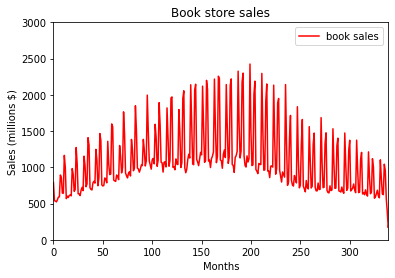

In [4]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0,339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()

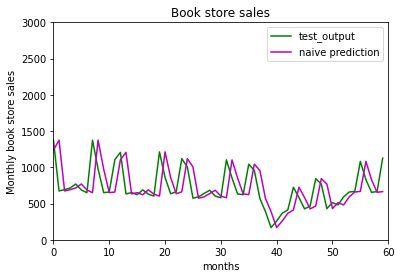

In [5]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1: -1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label = 'test_output')
plt.plot(x, naive_prediction, 'm-', label = 'naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [6]:
# standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/ stddev

In [7]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months - MIN, train_months-1, 1), dtype=np.float32)
train_Y = np.zeros((train_months - MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
   train_X[i, -(i+MIN):, 0] = train_sales_std[0: i+MIN]
   train_Y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months - MIN, test_months-1, 1), dtype=np.float32)
test_Y = np.zeros((test_months - MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
   test_X[i, -(i+MIN):, 0] = test_sales_std[0: i+MIN]
   test_Y[i, 0] = test_sales_std[i+MIN]

# Create Dataset objects
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_Y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_Y))

In [8]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
  def forward(self, inputs):
    return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128,1))


# Loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model
train_model(model,device,EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.9038 - mae: 0.7023 - val_loss: 0.9267 - val_mae: 0.8152
Epoch 2/100 loss: 0.8916 - mae: 0.6414 - val_loss: 0.9915 - val_mae: 0.8450
Epoch 3/100 loss: 0.7023 - mae: 0.5940 - val_loss: 0.6954 - val_mae: 0.6691
Epoch 4/100 loss: 0.5480 - mae: 0.5461 - val_loss: 0.2042 - val_mae: 0.3237
Epoch 5/100 loss: 0.5250 - mae: 0.5053 - val_loss: 0.3316 - val_mae: 0.4389
Epoch 6/100 loss: 0.5672 - mae: 0.5412 - val_loss: 0.2611 - val_mae: 0.4213
Epoch 7/100 loss: 0.5598 - mae: 0.5324 - val_loss: 0.2451 - val_mae: 0.3906
Epoch 8/100 loss: 0.4599 - mae: 0.4935 - val_loss: 2.8103 - val_mae: 1.4887
Epoch 9/100 loss: 0.6436 - mae: 0.6083 - val_loss: 0.5732 - val_mae: 0.6185
Epoch 10/100 loss: 0.4961 - mae: 0.5316 - val_loss: 0.4957 - val_mae: 0.5780
Epoch 11/100 loss: 0.4553 - mae: 0.4945 - val_loss: 0.3740 - val_mae: 0.4792
Epoch 12/100 loss: 0.4216 - mae: 0.4734 - val_loss: 0.3497 - val_mae: 0.4425
Epoch 13/100 loss: 0.4158 - mae: 0.4811 - val_loss: 0.1973 - val_mae: 0.3027
Epoch 14

[0.10823745342592399, 0.18497802689671516]

In [9]:
# create naive prediction based on standardized date
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction - test_output))

mean_abs_error = np.mean(np.abs(naive_prediction - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.39998654
naive test mean abs:  0.4534308
